# Exploratory and Statistical Analysis on the Data

We will perform exploratory and statistical analysis on our data, to have preliminary answers to our research questions. We will observe and investigate the influence of the following factors on the ending score: 

1) The genre(s) of the movie
2) The release date and influence of historical events
3) The key personnel of the movie (actors, directors...)
4) The movie' "success" (financial performance and popularity)
5) The region of production and the language of the movie
6) The budget and production scale of the movie
7) The movie's duration
8) The fact that the movie is part of collection of movies (e.g. part of a trilogy)


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import ast
import scipy.stats as stats


from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency


In [3]:
# path
DATA_FOLDER = 'src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_final.tsv'

# Dataset loading
movies = pd.read_csv(MOVIE_DATASET, sep='\t')

## 1. Movie genres

How does the genre of a movie influence the type of ending it has (happy, tragic)? Certain genres may have a higher likelihood of happy or tragic endings.

### 1.1 Cleaning and Filtering Movie Genres

What kind of genres do we have in this dataset ? And how many movies for each genre ?

In [64]:
#Drop rows with no score
movies['Movie genres'] = movies['Movie genres'].str.lower()
genre_counts = movies['Movie genres'].str.split(', ').explode().value_counts().reset_index()
genre_counts.columns = ['Genre', 'Number of movies']
genre_counts = genre_counts.sort_values(by='Number of movies', ascending=False)
print("Number of genres:", len(genre_counts))

Number of genres: 346


We observe that we have 346 different movie genres. We will keep only the most common ones (some genres have only one or a few films), and choose the ones that have .

In [65]:
genre_counts = genre_counts[genre_counts['Number of movies'] > 500]
print("Number of genres of our interest for our analysis: ", len(genre_counts))

Number of genres of our interest for our analysis:  36


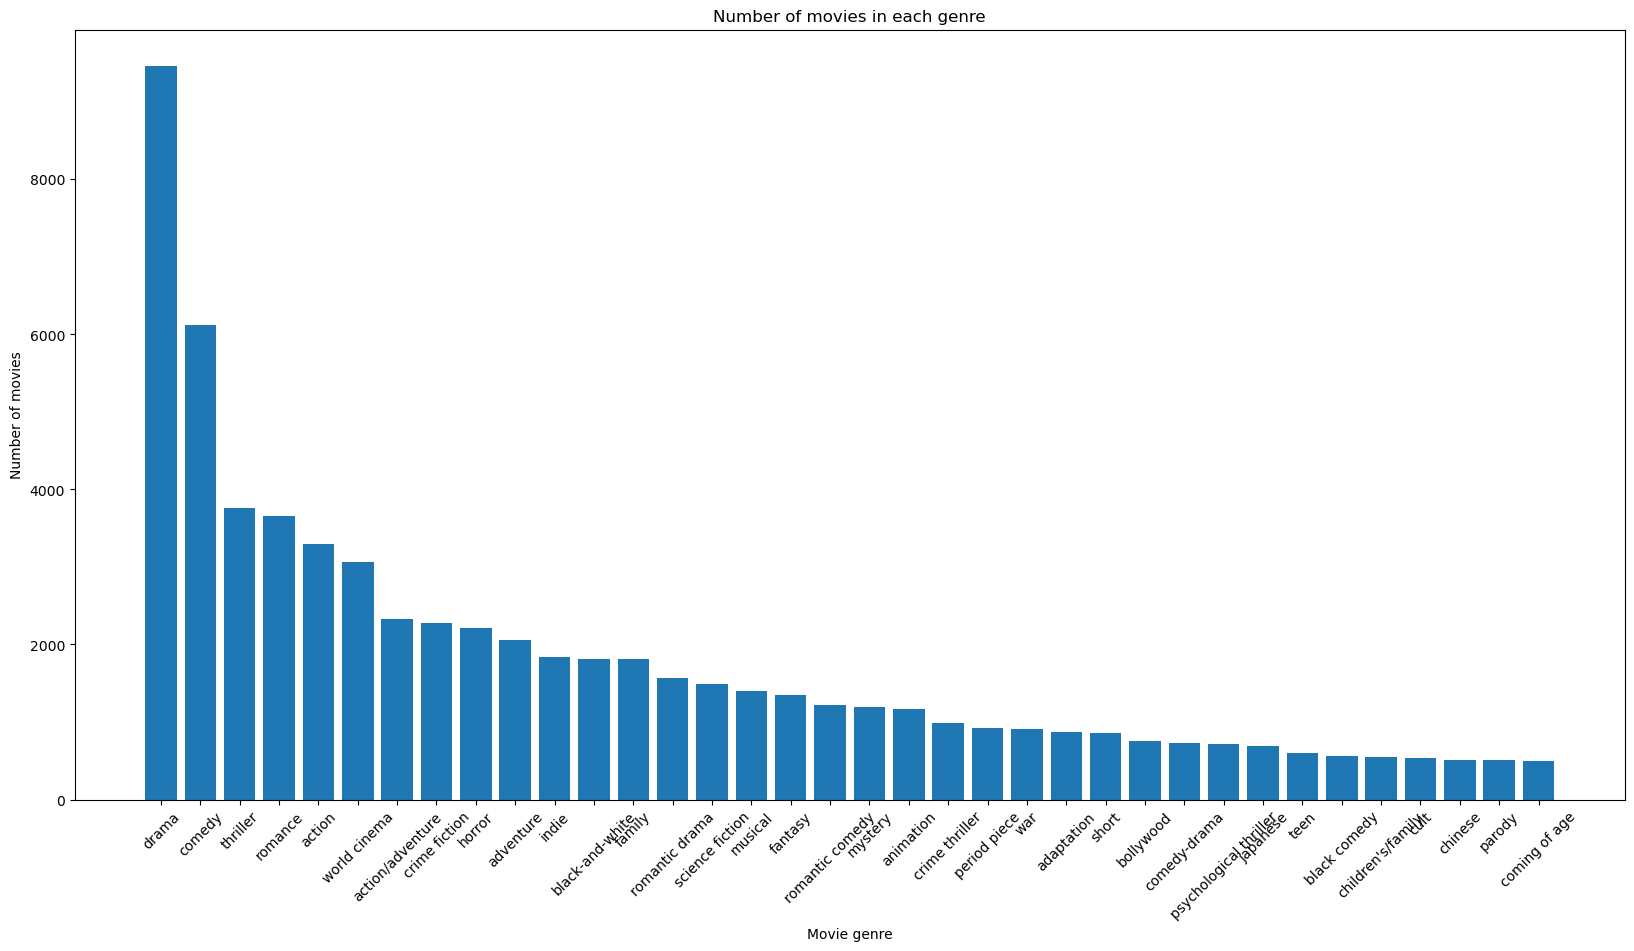

In [66]:
# Plot the number of movies in each genre 
plt.figure(figsize=(20, 10))
plt.bar(genre_counts['Genre'], genre_counts['Number of movies'])
plt.xticks(rotation=45)
plt.xlabel('Movie genre')
plt.ylabel('Number of movies')
plt.title('Number of movies in each genre')
plt.show()


Now that we have cleaned, regrouped and selected the movie genres, we will create a new dataset with only the movies that have any of these genres of our interest.

In [67]:
# New dataframe 
movies_genres = movies.copy()
movies_genres = movies_genres.dropna(subset=['Movie genres'])
movies_genres = movies_genres.dropna(subset=['Score'])
movies_genres['Movie genres'] = movies_genres['Movie genres'].str.split(', ')
movies_genres = movies_genres.explode('Movie genres')
movies_genres = movies_genres.reset_index(drop=True)
movies_genres['Movie genres'] = movies_genres['Movie genres'].str.lower()

# Remove the rows of the movies_genres dataframe which genre is not in the genre_counts dataframe
movies_genres = movies_genres[movies_genres['Movie genres'].isin(genre_counts['Genre'])]
movies_genres = movies_genres.reset_index(drop=True)

Now that we have clean data with only the most relevant genres for each film, we can anlayze it.

### 1.2 Exploratory analysis of the relationship between ending score and the movie genres

First we can observe the mean score of ending for each movie genre.

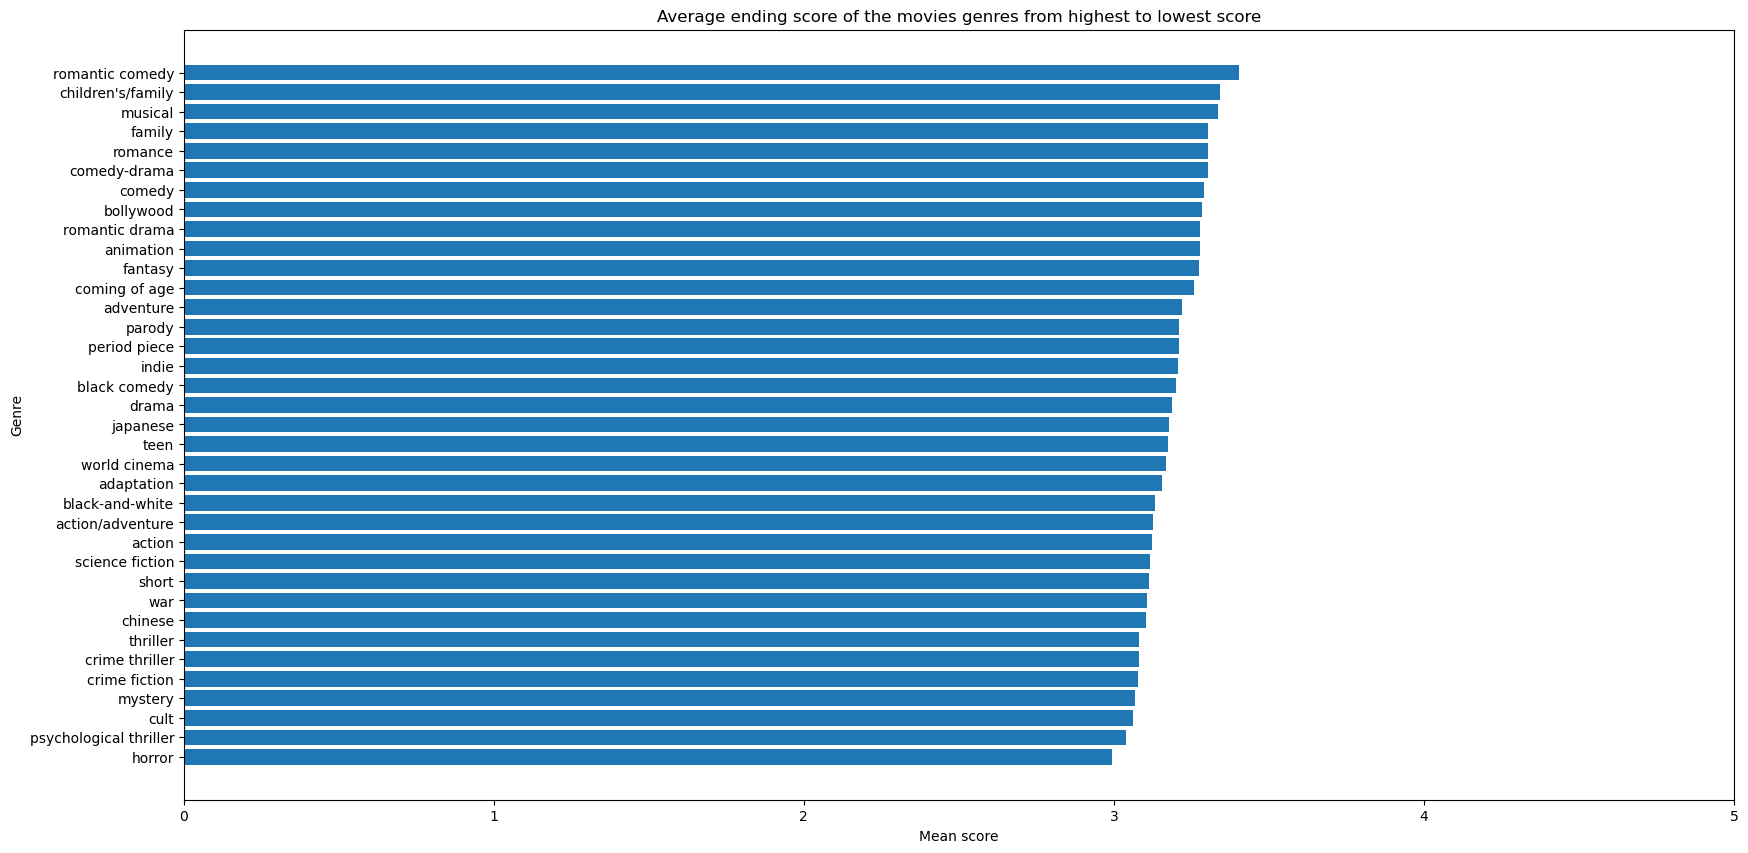

In [68]:
# Mean ending score for each genre
genre_scores = movies_genres.groupby('Movie genres').agg({'Score': 'mean', 'Movie genres': 'count'})
genre_scores.columns = ['Mean score', 'Number of movies']
genre_scores = genre_scores.reset_index()
genre_scores = genre_scores.sort_values(by='Mean score', ascending=True)
genre_scores = genre_scores.reset_index(drop=True)

# Plot of the average score of the movie genres from best to worst ending score
plt.figure(figsize=(20, 10))
plt.barh(genre_scores['Movie genres'], genre_scores['Mean score'])
plt.xlim(0, 5)
plt.xlabel('Mean score')
plt.ylabel('Genre')
plt.title('Average ending score of the movies genres from highest to lowest score')
plt.show()

We observe that the average ending score does vary from one genre to the other but the difference is not that important. 
Let's have a look at what genres have the five highest and five lowest ending scores.
We can then have a look at the distribution of the movies per score for the highest ending score genre and the lowest ending score genre.

In [69]:
#Highest mean score genres
genre_high_scores = genre_scores.sort_values(by='Mean score', ascending=False)

print("The 5 genres with the highest mean score are:")
print(genre_high_scores.head(5))

The 5 genres with the highest mean score are:
         Movie genres  Mean score  Number of movies
35    romantic comedy    3.405094              1217
34  children's/family    3.342391               552
33            musical    3.337151              1397
32             family    3.303265              1807
31            romance    3.302931              3651


In [70]:
#Lowest mean score genres
print("The 5 genres with the lowest mean score are:")
print(genre_high_scores.tail(5))

The 5 genres with the lowest mean score are:
             Movie genres  Mean score  Number of movies
4           crime fiction    3.078647              2276
3                 mystery    3.068792              1192
2                    cult    3.060150               532
1  psychological thriller    3.037921               712
0                  horror    2.993207              2208


In [71]:
#Distibution of the number of movies per ending score for the genre with the highest average score and the score withe the lowest average score
worst_genre = genre_high_scores.tail(1)['Movie genres'].values[0]
best_genre = genre_high_scores.head(1)['Movie genres'].values[0]

worst_genre_scores = movies_genres[movies_genres['Movie genres'] == worst_genre]['Score']
best_genre_scores = movies_genres[movies_genres['Movie genres'] == best_genre]['Score']

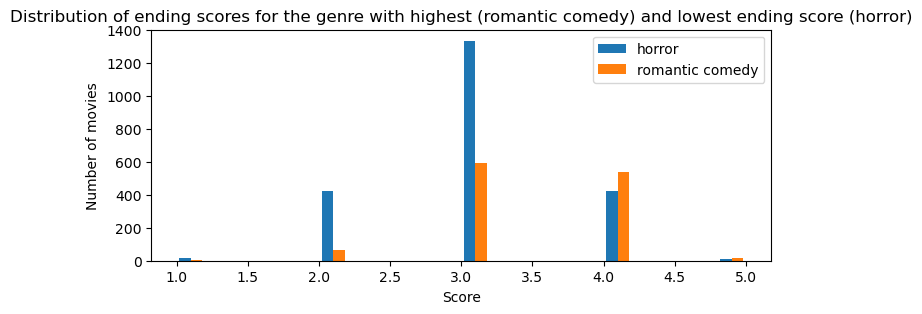

In [72]:
#PLot a histogram where the x axis is the score from 1 to 5 and the y axis is the number of movies that have this score, but for each score I want two bars one for the worst genre and one for the best genre
plt.figure(figsize=(8, 3))
plt.hist([worst_genre_scores, best_genre_scores], bins=20, range=(1, 5), label=[worst_genre, best_genre])
plt.xlabel('Score')
plt.ylabel('Number of movies')
plt.title('Distribution of ending scores for the genre with highest (romantic comedy) and lowest ending score (horror)')
plt.legend()
plt.show()

We observe that these 2 genres have significant different distributions.

To get more insight on this, we will perform some statistical tests to further explore if there is a relationship between the genre of a movie and its ending.

### 1.3 Statistical analysis of the relationship between ending score and the movie genres

We can perform can perform a Chi-square test, which is used to determine whether there is a significant association between two categorical variables. Using it, we can determine if the movie genres and the ending scores are related or not, since these two variables are categorical. 

Null Hypothesis: Movie genres and ending scores are independent.

Alternative Hypothesis: Movie genres and ending scores are not independent.

Chi-Square Statistic: 1469.3927914378085
P-Value: 3.135541267890827e-220
Degrees of Freedom: 140


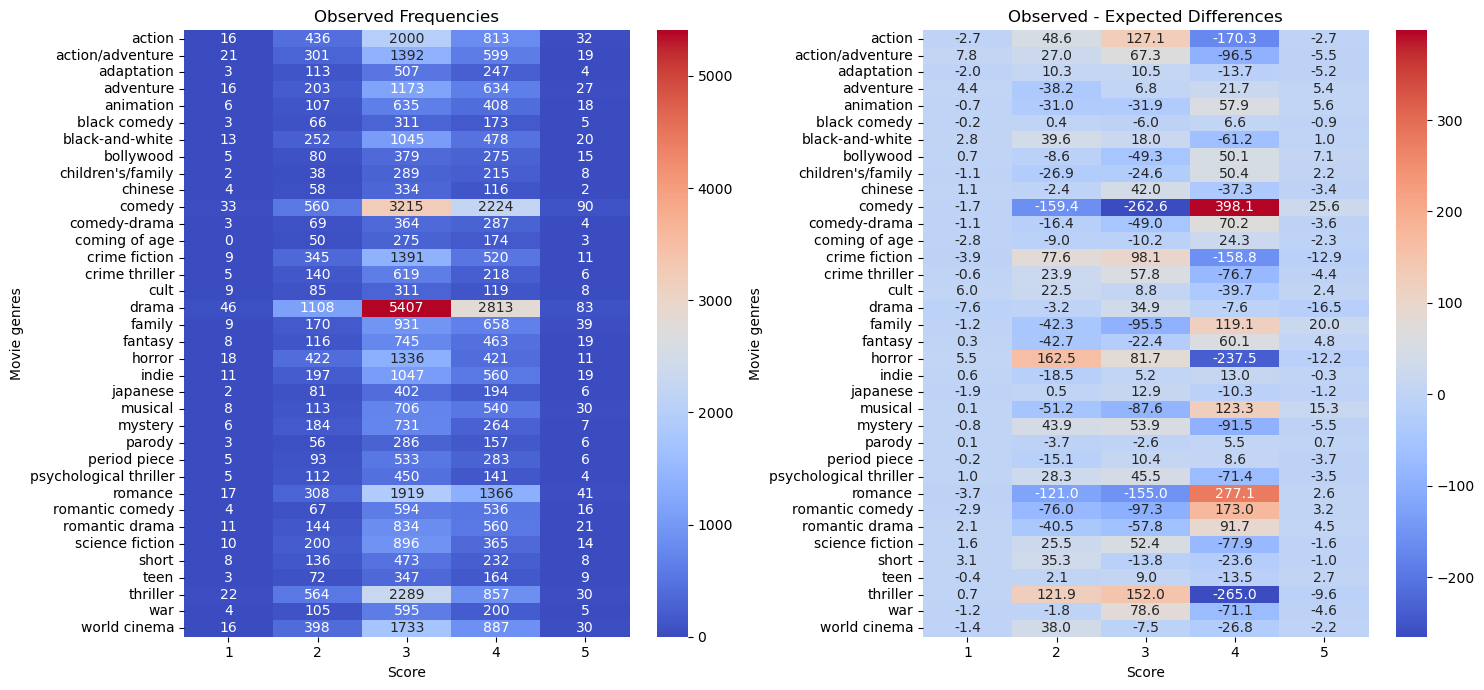

In [73]:
#Chi-square test


genre_score_counts = movies_genres.groupby(['Movie genres', 'Score']).size().unstack(fill_value=0)
chi2, p, dof, expected = chi2_contingency(genre_score_counts)

print("Chi-Square Statistic:", chi2)
print("P-Value:", p)
print("Degrees of Freedom:", dof)

# Create subplots for two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Heatmap of observed frequencies
sns.heatmap(genre_score_counts, annot=True, cmap="coolwarm", fmt="d", ax=axes[0])
axes[0].set_title("Observed Frequencies")

# Heatmap of differences (observed - expected)
sns.heatmap(genre_score_counts - expected, annot=True, cmap="coolwarm", fmt=".1f", ax=axes[1])
axes[1].set_title("Observed - Expected Differences")

plt.tight_layout()
plt.show()

The Chi-square p value is extremely low and smaller than 0.05 (significance threshold), therfore we can reject the null hypothesis.

From the heatmaps, we can see the observed frequencies of movies for each score for each genre and the difference between the expected frequency (what we would expect to see if there were no relationship between movie genres and their ending scores). For example, we can that comedy has a lot more movies with an ending score of 4 (happy ending) than what we would expect if there was no link between genre and ending score.

Although this test proves us that there is a link between the movie genres and the ending of a movie (score), this value is extremely low. It can be explained by a large number of genres, or the fact that some genres have a lot more movies than other. To remedy this, we will have to test a more balanced sample of genres later.

Future steps to explore:

1) Try different statistical tests. To see if there is a significant difference in the average ending score for all genres, we could also perform an ANOVA test (or t-test between 2 genres).
HOWEVER: 
    - ANOVA assumes normally distributed data and similar variances across groups. We will have to verify those assumptions before performing this test.

    - ANOVA only tells us if there is a difference somewhere among the genres, not which specific genres differ.

    If the confitions are not verified, we could also perform the Mann-Whitney U test for example.

2) We can use a different subset of movie genres because since some genres are more represented (e;g; 'drama'), it might influence the results that we have. We can test movie genres that have a sufficient number of movies but not too high either. Also, there are multiple genres for one movie, we might need to take only one into account, but in this case, which one?



### 2. Release date and Influence of historical events

Further analysis will focus on investigating correlations between movies and historical events through various approaches:
1. **Temporal analysis**: Investigate if there is an overall correlation between the happy endings of movies and global conflicts or wars. Account for production delays by shifting the timelines of movies and events by x years to identify where the strongest correlation lies. Possibly 'x' could be determined using a mean production time or finding precise data for the production of eahc movie. This will require to perform temporal analysis by clustering events and movies into defined time periods (e.g., decades).
2. **Geographic Insights**: Explore regional and country-level correlations to identify whether specific regions or nations are disproportionately reflected in movies.
3. **Thematic Connections**: Analyze if movies with themes similar to historical events (e.g., war, diplomacy) reflect the outcomes or nature of those events in their narratives and endings.
4. **Impact of Crisis Severity**: Investigate whether movies produced during or after high-fatality crises tend to have darker or more reflective endings.

### 3. Key personnel (directors)

In [6]:
from src.scripts.rq_3 import get_analysis, get_director_avg_score, get_director_score_variance, get_director_avg_score_vs_avg_revenue, get_director_avg_score_vs_avg_vote_average, t_test_avg_score_on_revenue, t_test_avg_score_on_vote_average, t_test_score_variance_on_revenue, t_test_score_variance_on_vote_average

save_path = "./assets/img/rq3/"

# Get the analysis
director_avg_score, director_score_variance, director_avg_revenue, director_avg_vote_average = get_analysis(MOVIE_DATASET)

In [7]:
# Get the average score of the directors
get_director_avg_score(director_avg_score, save_path=save_path)


In [8]:
# Get the variance of the scores of the directors
get_director_score_variance(director_score_variance, save_path=save_path)

In [10]:
# Get the average score of the directors vs the average revenue
get_director_avg_score_vs_avg_revenue(director_avg_score, director_score_variance, director_avg_revenue, save_path=save_path)

In [11]:
# Get the average score of the directors vs the average vote average
get_director_avg_score_vs_avg_vote_average(director_avg_score, director_score_variance, director_avg_vote_average, save_path=save_path)

In [13]:
# use t test to check if the average score is significantly different between directors with high and low revenue
t_test_avg_score_on_revenue(director_avg_score, director_avg_revenue)

The average score is significantly different between directors with high and low revenue


True

In [14]:
# use t test to check if the average score is significantly different between directors with high and low vote average
t_test_avg_score_on_vote_average(director_avg_score, director_avg_vote_average)

The average score is significantly different between directors with high and low vote average


True

In [15]:
# use t test to check if the score variance is significantly different between directors with high and low revenue
t_test_score_variance_on_revenue(director_score_variance, director_avg_revenue)

The score variance is not significantly different between directors with high and low revenue


False

In [16]:
# use t test to check if the score variance is significantly different between directors with high and low vote average
t_test_score_variance_on_vote_average(director_score_variance, director_avg_vote_average)

The score variance is not significantly different between directors with high and low vote average


False

### 4. Movie's 'success'

Is there a correlation between a movie’s ending and its success (ratings, box office revenue, etc.)?

We will explore whether happy or tragic endings have any impact on a movie's popularity or financial performance.

To do so, we used the the tmdb dataset to augment our dataset and to provide the information of the box office revenue (more complete because in our own dataset we only had this information for ~10% of the movies) and the vote average, which is an average of the audience's rating on the movie. 

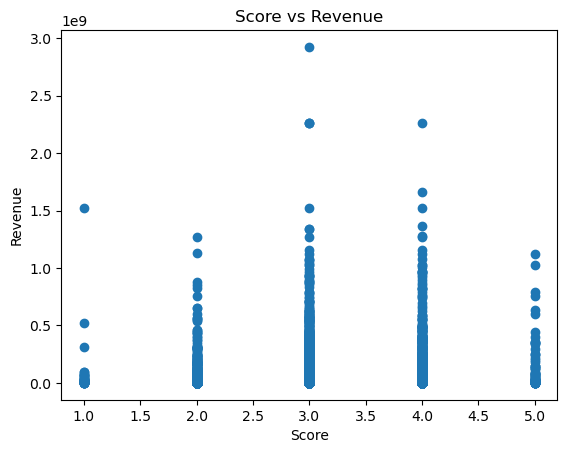

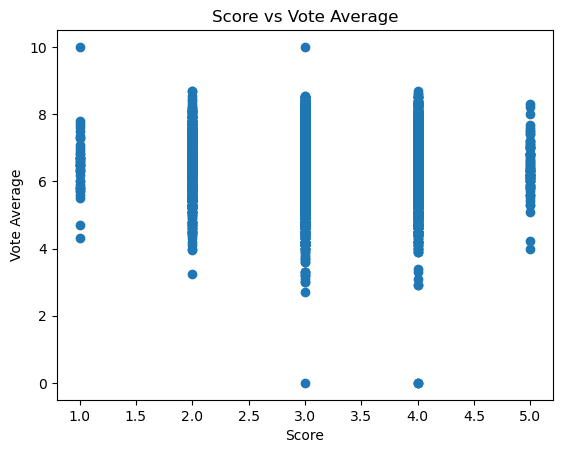

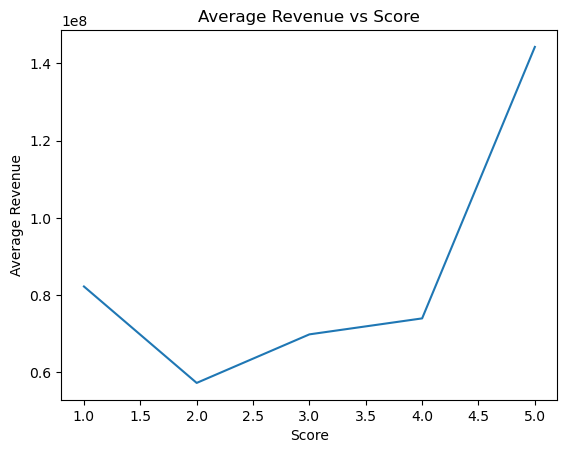

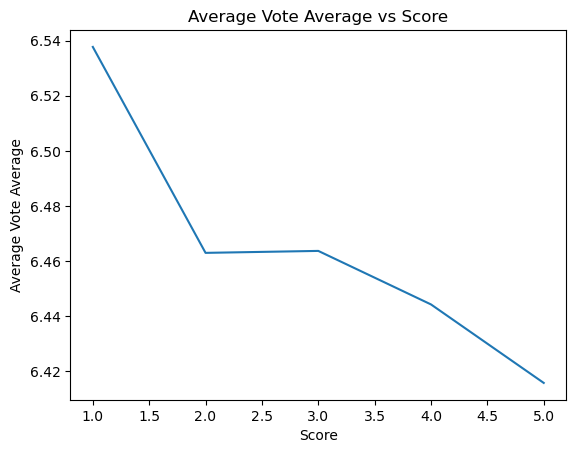

We use a t-test to test if the average revenue is different for movies with score 1 and movies with score 5
t-statistic: -1.3594096978481334
p-value: 0.17660901320022113
The difference is not statistically significant
We use a t-test to test if the average vote average is different for movies with score 1 and movies with score 5
t-statistic: 0.7687718574950436
p-value: 0.4435647150911646
The difference is not statistically significant


In [75]:
# %%
# drop movies without vote average or revenue
movies_filtered = movies.dropna(subset=['vote_average', 'revenue'])

# drop movies with revenue less than 1000
movies_filtered = movies_filtered[movies_filtered['revenue'] > 1000]

# %%
# plot score vs revenue
plt.scatter(movies_filtered['Score'], movies_filtered['revenue'])
plt.xlabel('Score')
plt.ylabel('Revenue')
plt.title('Score vs Revenue')
plt.show()

# %%
# plot score vs vote average
plt.scatter(movies_filtered['Score'], movies_filtered['vote_average'])
plt.xlabel('Score')
plt.ylabel('Vote Average')
plt.title('Score vs Vote Average')
plt.show()


# %%
# calculate the average revenue for each score
average_revenue = movies_filtered.groupby('Score')['revenue'].mean()
average_revenue = average_revenue.sort_index()

# plot average revenue vs score
plt.plot(average_revenue)
plt.xlabel('Score')
plt.ylabel('Average Revenue')
plt.title('Average Revenue vs Score')
plt.show()

# %%
# calculate the average vote average for each score
average_vote_average = movies_filtered.groupby('Score')['vote_average'].mean()
average_vote_average = average_vote_average.sort_index()

# plot average vote average vs score
plt.plot(average_vote_average)
plt.xlabel('Score')
plt.ylabel('Average Vote Average')
plt.title('Average Vote Average vs Score')
plt.show()

# %%
print("We use a t-test to test if the average revenue is different for movies with score 1 and movies with score 5")

movies_score_1_revenue = movies_filtered[movies_filtered['Score'] == 1.0]['revenue'].astype(float)
movies_score_5_revenue = movies_filtered[movies_filtered['Score'] == 5.0]['revenue'].astype(float)

t_stat, p_value = ttest_ind(movies_score_1_revenue, movies_score_5_revenue)

print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The difference is statistically significant')
else:
    print('The difference is not statistically significant')

# %%
print("We use a t-test to test if the average vote average is different for movies with score 1 and movies with score 5")
movies_score_1_vote_average = movies_filtered[movies_filtered['Score'] == 1.0]['vote_average'].astype(float)
movies_score_5_vote_average = movies_filtered[movies_filtered['Score'] == 5.0]['vote_average'].astype(float)

t_stat, p_value = ttest_ind(movies_score_1_vote_average, movies_score_5_vote_average)

print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The difference is statistically significant')
else:
    print('The difference is not statistically significant')

# %%

## 5. Region/Country of production of the movie

### 1. Average Movie Score by Country
A horizontal bar chart showing the **average movie score** for countries with at least **10 films**.

### 2. Evolution of Average Movie Scores Over Time
A line plot displaying the **average movie score** per year, filtered to include only years with at least **50 films**.


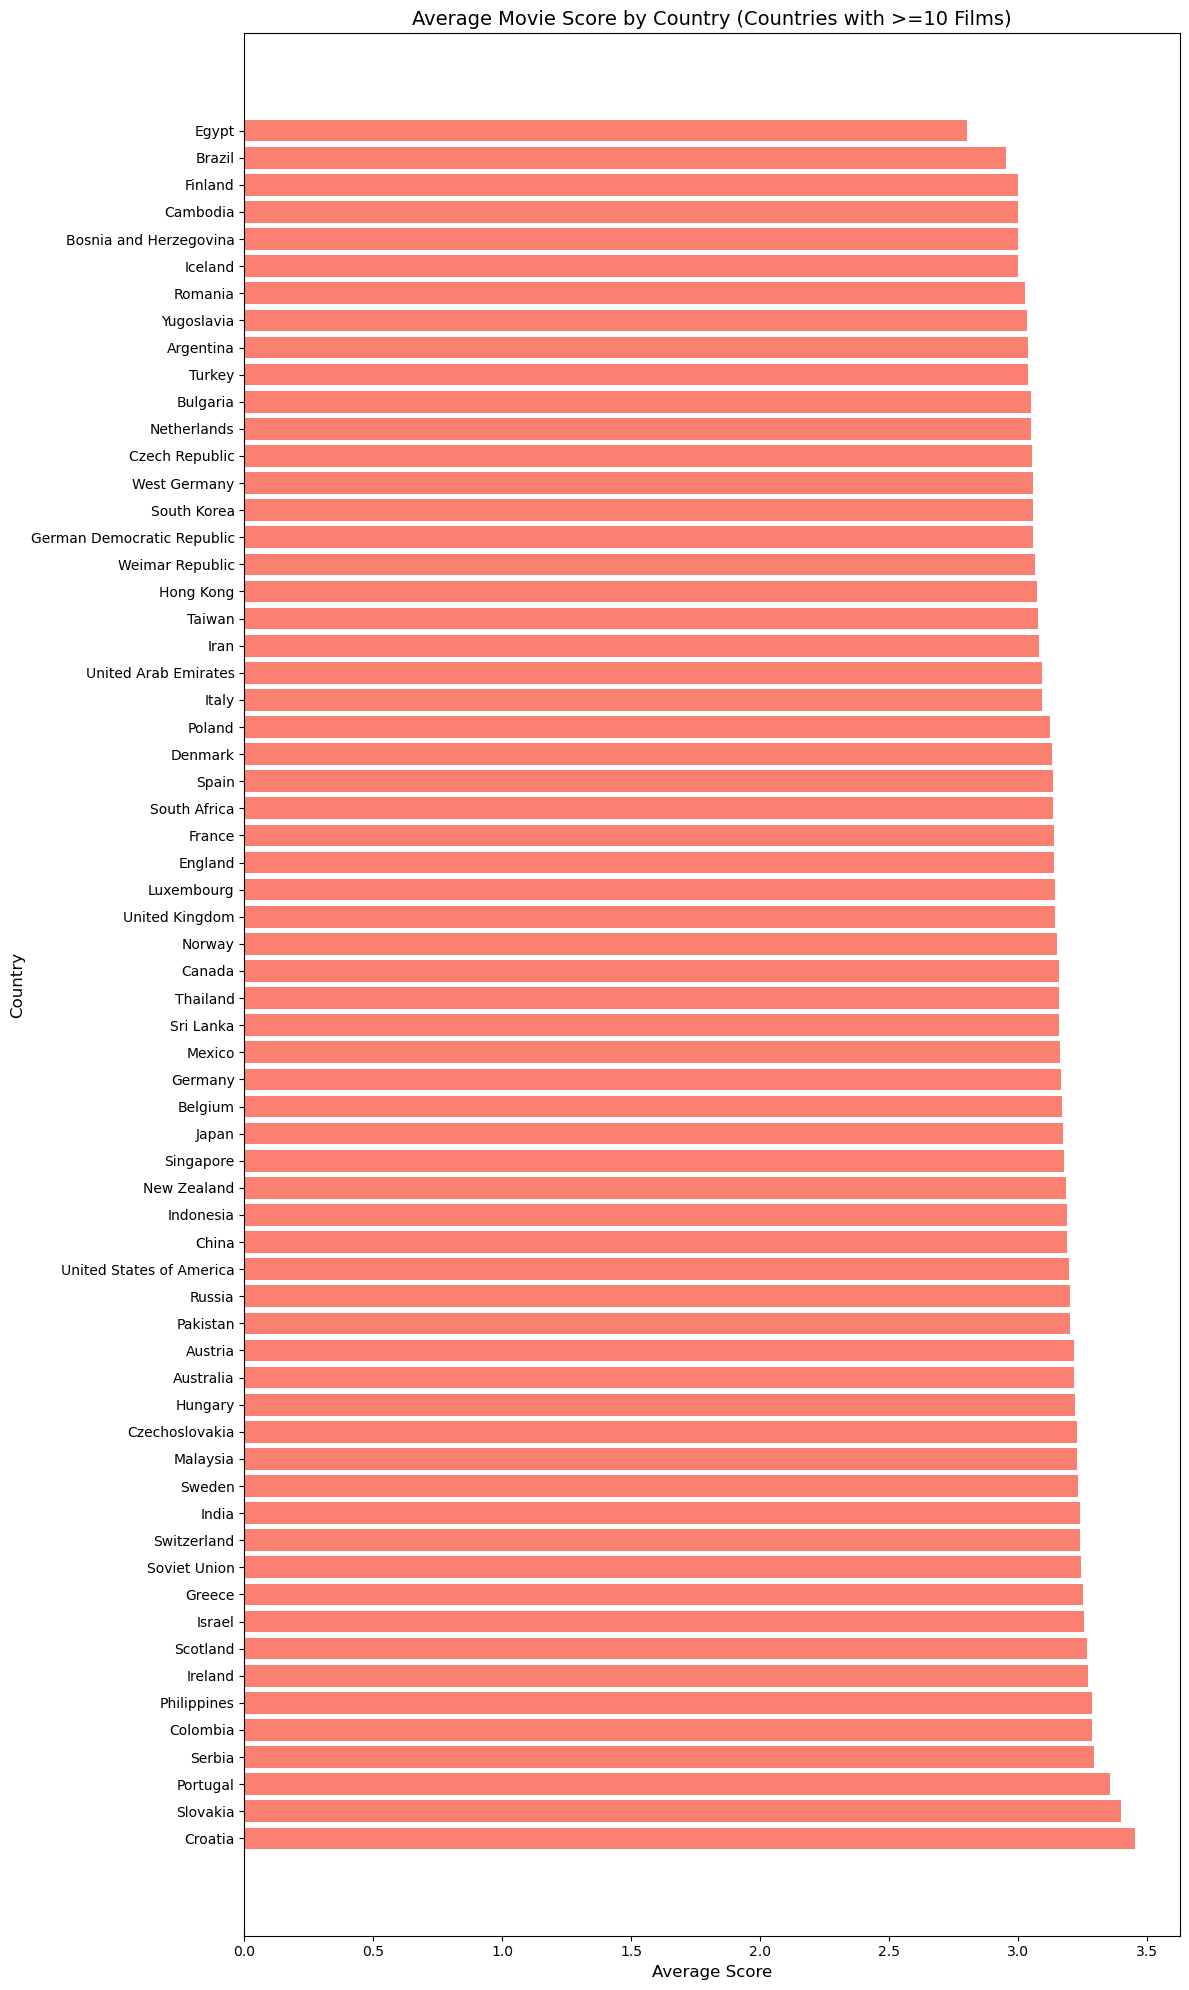

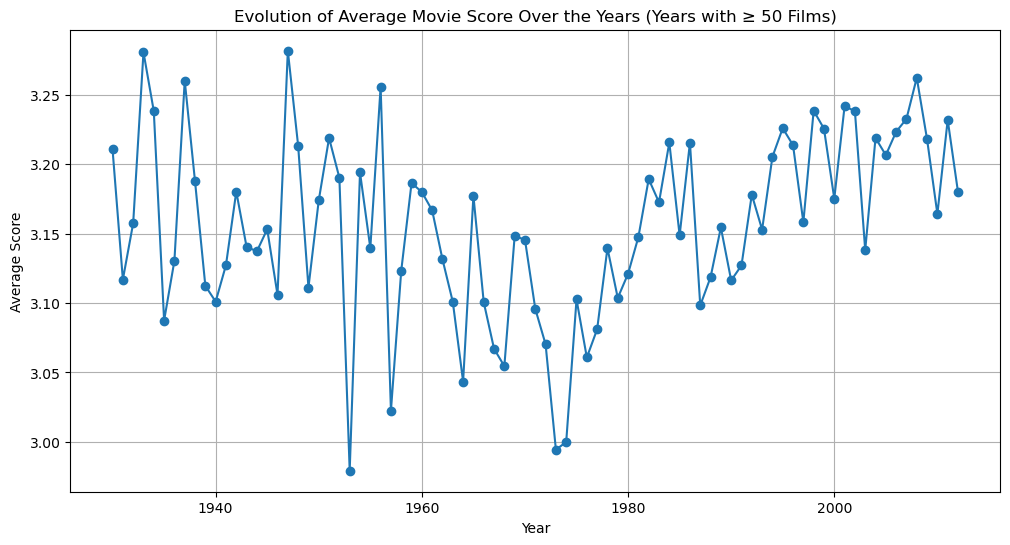

In [76]:
file_path = 'src/data/movies_dataset_final.tsv'
movies_df = pd.read_csv(file_path, sep='\t')

# Split the 'Movie countries' column into individual countries
movies_df = movies_df.assign(Country=movies_df['Movie countries'].str.split(", ")).explode('Country')

# Calculate average score and film count per country
country_stats = movies_df.groupby('Country').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
).sort_values(by='Average_Score', ascending=False)

# Filter countries with at least 10 films
country_stats_10_plus = country_stats[country_stats['Film_Count'] >= 10]

# Plot for countries with at least 10 films
plt.figure(figsize=(12, 20))
plt.barh(country_stats_10_plus.index, country_stats_10_plus['Average_Score'], color='salmon')
plt.ylabel('Country', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Country (Countries with >=10 Films)', fontsize=14)
plt.tight_layout()
plt.show()

score_and_count_by_year = movies_df.groupby('Movie release date').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
)

filtered_data = score_and_count_by_year[score_and_count_by_year['Film_Count'] >= 50]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['Average_Score'], marker='o', linestyle='-')
plt.title('Evolution of Average Movie Score Over the Years (Years with ≥ 50 Films)')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()


## 6. Budget and Production scale

### Do budget and production scale affect the type of ending chosen? Exploring whether high-budget films tend to favor certain endings (e.g., happy endings for wider audience appeal) could reveal if financial considerations impact storytelling choices.


Remove movies with missing values for budget

In [77]:
movies = pd.read_csv(MOVIE_DATASET, sep='\t')
# Count rows where 'budget' is NaN or 0
missing_or_zero_count = movies[(movies['Budget'].isnull()) | (movies['Budget'] == 0)].shape[0]
# Calculate the percentage of these rows
percentage_missing_or_zero = (missing_or_zero_count / len(movies)) * 100
# Remove rows where 'budget' is NaN or 0
movies = movies[(movies['Budget'].notnull()) & (movies['Budget'] > 0)]
# Verify removal
remaining_rows = len(movies)
missing_productions = movies['Production'].isna().sum()


In [78]:
# Function to extract production names
def extract_production_names(production_list):
    # Ensure the input is a list of dictionaries
    if isinstance(production_list, str):
        # If the column contains a string representation of a list (like JSON), convert it to a list
        try:
            production_list = ast.literal_eval(production_list)
        except (ValueError, SyntaxError):
            return []  # Return empty list if there's a parsing error

    # If it's a valid list of dictionaries, extract the 'name'
    if isinstance(production_list, list):
        return [item['name'] for item in production_list if isinstance(item, dict) and 'name' in item]
    return []

# Apply the function to the 'productions' column to extract production names
movies['production_names'] = movies['Production'].apply(extract_production_names)

# Count the number of missing values in the 'production_names' column
missing_production_names = movies['production_names'].isna().sum()


In [79]:
# Extract the first production name for each film
movies['first_production_name'] = movies['production_names'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)


### Statistics

In [80]:
# Calculate the correlation between budget and score
correlation = movies['Budget'].corr(movies['Score'])
print(f"Correlation between budget and score: {correlation:.2f}")

Correlation between budget and score: 0.04


We use an ANOVA (Analysis of Variance) test to determine if the mean scores across the groups of films, defined by their first production, differ significantly. This test is appropriate because we are comparing multiple groups (each corresponding to a different production) on a continuous variable (the film score). ANOVA helps to assess whether the variation in scores is due to differences between the production groups or if it can be attributed to random chance.

In [81]:

# Group by the first production name and calculate the mean score for each production
production_score = movies.groupby('first_production_name')['Score'].mean()

# Perform ANOVA to test if there are significant differences in the scores between production groups
anova_result = stats.f_oneway(*(movies[movies['first_production_name'] == prod]['Score'] for prod in production_score.index))

# Print the result in a cleaner format
if anova_result.pvalue < 0.05:
    print("ANOVA result: There are significant differences in scores between production groups.")
else:
    print("ANOVA result: There are no significant differences in scores between production groups.")

print(f"ANOVA p-value: {anova_result.pvalue:.4f}")


ANOVA result: There are significant differences in scores between production groups.
ANOVA p-value: 0.0076


## 7. Movie's duration

### How do movie endings vary by film length ? This question would explore whether movies of different lengths (e.g., short vs. feature-length) tend to have different types of endings.


Threshold: 100, p-value: 0.0003 - Significant
Mean Score for Short Movies: 0.05
Mean Score for Feature-length Movies: 0.06
Difference in means: 0.01

Threshold: 130, p-value: 0.0088 - Significant
Mean Score for Short Movies: 0.05
Mean Score for Feature-length Movies: 0.07
Short films mean increased by 0.00 compared to previous threshold
Feature-length films mean increased by 0.01 compared to previous threshold
Difference in means: 0.01

Threshold: 140, p-value: 0.0432 - Significant
Mean Score for Short Movies: 0.06
Mean Score for Feature-length Movies: 0.07
Short films mean increased by 0.00 compared to previous threshold
Feature-length films mean increased by 0.00 compared to previous threshold
Difference in means: 0.01

Threshold: 210, p-value: 0.0123 - Significant
Mean Score for Short Movies: 0.07
Mean Score for Feature-length Movies: 0.02
Short films mean increased by 0.01 compared to previous threshold
Feature-length films mean decreased by 0.05 compared to previous threshold
Diff

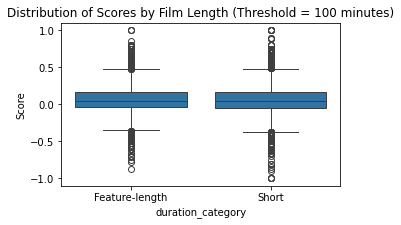

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.06    0.05 0.18   5680
Short              0.06    0.05 0.18   5680

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=249.4913, p-value=0.0000
Feature-length Movies: Stat=234.5275, p-value=0.0000
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution does not follow a normal distribution.

Levene's Test for Equality of Variances: Statistic=4.0108, p-value=0.0452
Variances between short and feature-length movies are not equal.

Mann-Whitney U Test Results:
Statistic: 15833950.0000, p-value: 0.0889
The difference between short and feature-length movies is not statistically significant.


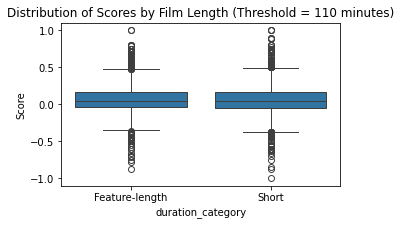

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.07    0.06 0.18   2500
Short              0.05    0.05 0.18   2500

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=115.7620, p-value=0.0000
Feature-length Movies: Stat=106.6960, p-value=0.0000
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution does not follow a normal distribution.

Levene's Test for Equality of Variances: Statistic=0.2399, p-value=0.6243
Variances between short and feature-length movies are equal.

Mann-Whitney U Test Results:
Statistic: 2991320.5000, p-value: 0.0088
The difference between short and feature-length movies is statistically significant.
Mean Score for Short Movies: 0.05
Mean Score for Feature-length Movies: 0.07
The mean score increases for feature-length movies compared to short movies.


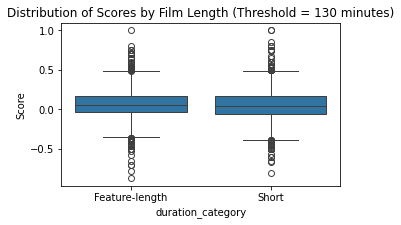

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.07    0.06 0.18   1808
Short              0.06    0.05 0.18   1808

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=97.7072, p-value=0.0000
Feature-length Movies: Stat=69.5218, p-value=0.0000
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution does not follow a normal distribution.

Levene's Test for Equality of Variances: Statistic=0.6749, p-value=0.4114
Variances between short and feature-length movies are equal.

Mann-Whitney U Test Results:
Statistic: 1570975.0000, p-value: 0.0432
The difference between short and feature-length movies is statistically significant.
Mean Score for Short Movies: 0.06
Mean Score for Feature-length Movies: 0.07
The mean score increases for feature-length movies compared to short movies.


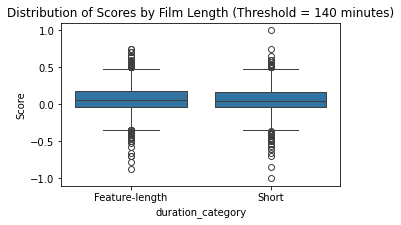

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.02    0.01 0.15    104
Short              0.07    0.06 0.18    104

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=7.1252, p-value=0.0284
Feature-length Movies: Stat=0.3064, p-value=0.8580
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution follows a normal distribution.

Levene's Test for Equality of Variances: Statistic=1.2651, p-value=0.2620
Variances between short and feature-length movies are equal.

Mann-Whitney U Test Results:
Statistic: 6495.0000, p-value: 0.0123
The difference between short and feature-length movies is statistically significant.
Mean Score for Short Movies: 0.07
Mean Score for Feature-length Movies: 0.02
The mean score does not increase for feature-length movies compared to short movies.


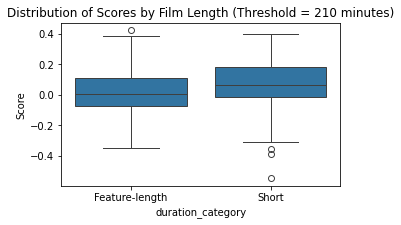

Descriptive Statistics by Duration Category:
                   mean  median  std  count
duration_category                          
Feature-length     0.01    0.00 0.14     81
Short              0.09    0.08 0.17     81

Normality Test (D'Agostino and Pearson):
Short Movies: Stat=8.7950, p-value=0.0123
Feature-length Movies: Stat=0.9144, p-value=0.6331
Short movies distribution does not follow a normal distribution.
Feature-length movies distribution follows a normal distribution.

Levene's Test for Equality of Variances: Statistic=2.4789, p-value=0.1174
Variances between short and feature-length movies are equal.

Mann-Whitney U Test Results:
Statistic: 4207.5000, p-value: 0.0019
The difference between short and feature-length movies is statistically significant.
Mean Score for Short Movies: 0.09
Mean Score for Feature-length Movies: 0.01
The mean score does not increase for feature-length movies compared to short movies.


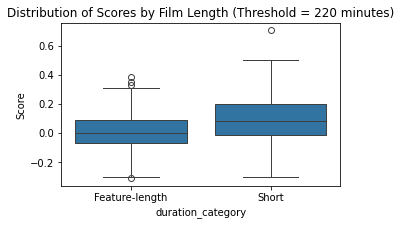

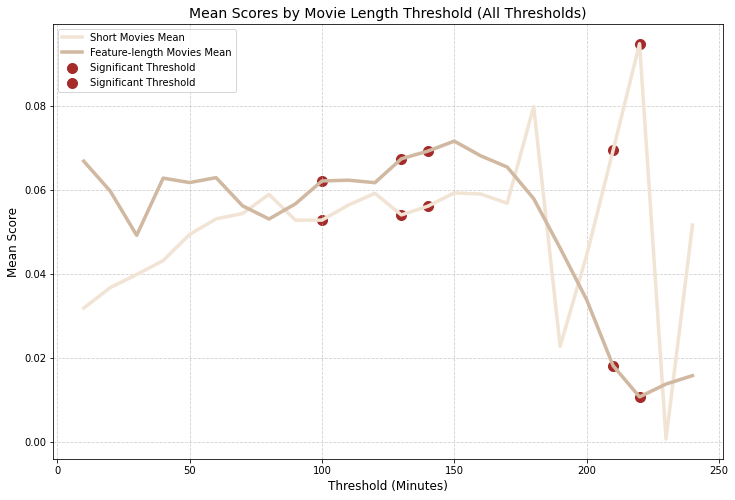


--- Analyzing with 3 categories: ---
Threshold: (20, 80), p-value: 0.0488 - Significant
Threshold: (35, 110), p-value: 0.0042 - Significant
Threshold: (45, 130), p-value: 0.0038 - Significant
Threshold: (50, 140), p-value: 0.0473 - Significant
Threshold: (90, 220), p-value: 0.0157 - Significant
Threshold: (100, 130), p-value: 0.0002 - Significant
Threshold: (110, 150), p-value: 0.0045 - Significant
Threshold: (170, 210), p-value: 0.0070 - Significant
Threshold: (190, 210), p-value: 0.0403 - Significant
Threshold: (150, 200), p-value: 0.0236 - Significant


In [1]:
%run src/scripts/rq_7.py

## 8. Collection of movies

### Do sequels or franchise movies follow different patterns in their endings compared to standalone films? 

Investigating whether franchise movies are more likely to have open-ended or happy endings to encourage future installments could reveal a unique trend in storytelling within cinematic universes.

Dataset loaded successfully from src/data/movies_dataset_final.tsv

----------------------------------------
Average Scores for Standalone vs. Collection Movies (before undersampling)
----------------------------------------
Standalone Movies (0)    : 0.05710735360171146
Collection Movies (1)    : 0.05245809989322952
----------------------------------------

Quantiles for Standalone and Collection Movies (before undersampling)
Quantile   Standalone (0)       Collection (1)
----------------------------------------
25th Percentile: -0.05                -0.05
50th Percentile: 0.05                 0.04
75th Percentile: 0.17                 0.16


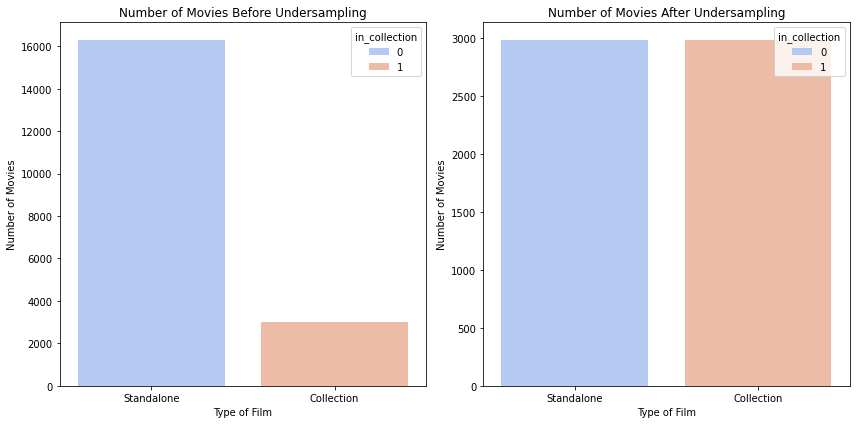


Kolmogorov-Smirnov Test for Normality:
Collection Films: p-value = 0.0000
Standalone Films: p-value = 0.0000

Normality assumption violated. Using Mann-Whitney U test...
Mann-Whitney U Test: p-value = 0.8881

There is no statistically significant difference between collection and standalone films' scores.

Average Scores for Standalone vs Collection Movies (After Undersampling):
Standalone Films: 0.05082445122898324
Collection Films: 0.05245809989322952


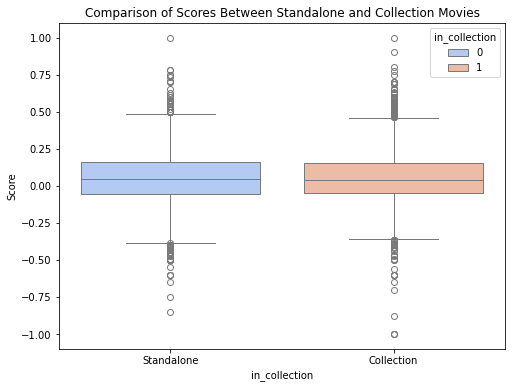

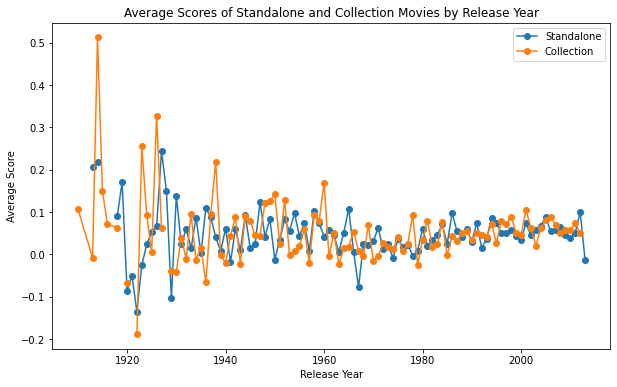

In [3]:
%run src/scripts/rq_8.py